
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# import dataset
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/aklefebvere/DS-Unit-2-Applied-Modeling/master/train-data.csv')

In [3]:
# Create train, test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=42)

In [4]:
# Create new train and val split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)

In [5]:
import math
def wrangle(df):
    # Create copy so it doesn't modify the origninal dataframe
    df = df.copy()
    
    # Filter out CNG, LPG, and Electric Fuel_type rows
    df = df[(df['Fuel_Type'] != 'CNG') & (df['Fuel_Type'] != 'LPG')
            & (df['Fuel_Type'] != 'Electric')]
    
    # Columns to drop
    drop = ['New_Price', 'Unnamed: 0']
    df = df.drop(columns=drop)
    
    # Rename columns
    df = df.rename(columns={'Price': 'Price_Lakh', 'Power': 'Power_bhp'})
    
    # Unit conversions
#     df['Price_INR'] = df['Price_Lakh'] * 100000
#     df['Price_USD'] = df['Price_INR'] * 0.013881
    
    # Zeros --> NaN (For Imputation)
    # Written this way just incase I need to replace more zeros
    zero = ['Seats']
    for i in zero:
        df[zero] = df[zero].replace(0.0,np.NaN)
        
    # Strip characters
    df['Power_bhp'] = df['Power_bhp'].str.strip('null bhp')
    df['Engine'] = df['Engine'].str.strip('CC')
    df['Mileage'] = df['Mileage'].str.strip('kmpl')
    
    # Convert series into numeric values
    df['Power_bhp'] = pd.to_numeric(df['Power_bhp'])
    df['Engine'] = pd.to_numeric(df['Engine'])
    df['Mileage'] = pd.to_numeric(df['Mileage'])
    
    return df

In [6]:
# wrangle each split
train = wrangle(train)
test = wrangle(test)
val = wrangle(val)

In [7]:
# Identify my target and x and y variables
target = 'Price_Lakh'

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test

y_train = np.log1p(train[target])
y_val = np.log1p(val[target])
y_test = np.log1p(test[target])

In [49]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Instansiate OrdinalEncoder
encoder = ce.OrdinalEncoder()

# encode X_train and X_val
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Impute by hand to keep the dataframe as a dataframe
X_train_encoded['Engine'] = X_train_encoded['Engine'].fillna(X_train_encoded['Engine'].median())
X_train_encoded['Power_bhp'] = X_train_encoded['Power_bhp'].fillna(X_train_encoded['Power_bhp'].median())
X_train_encoded['Seats'] = X_train_encoded['Seats'].fillna(X_train_encoded['Seats'].median())

X_val_encoded['Engine'] = X_val_encoded['Engine'].fillna(X_val_encoded['Engine'].median())
X_val_encoded['Power_bhp'] = X_val_encoded['Power_bhp'].fillna(X_val_encoded['Power_bhp'].median())
X_val_encoded['Seats'] = X_val_encoded['Seats'].fillna(X_val_encoded['Seats'].median())

# insansiate XGBRegressor model
model = XGBRegressor(
    n_estimators = 1000,
    max_depth = 7,
    learning_rate = 0.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train,
         eval_set=eval_set,
         eval_metric='mae',
         early_stopping_rounds=150)

[19:01:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.773916	validation_1-mae:0.776738
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 150 rounds.
[1]	validation_0-mae:0.402589	validation_1-mae:0.40698
[2]	validation_0-mae:0.232976	validation_1-mae:0.246553
[3]	validation_0-mae:0.158384	validation_1-mae:0.183524
[4]	validation_0-mae:0.127705	validation_1-mae:0.160148
[5]	validation_0-mae:0.116204	validation_1-mae:0.155325
[6]	validation_0-mae:0.107861	validation_1-mae:0.151551
[7]	validation_0-mae:0.103011	validation_1-mae:0.150735
[8]	validation_0-mae:0.100352	validation_1-mae:0.149032
[9]	validation_0-mae:0.097053	validation_1-mae:0.146478
[10]	validation_0-mae:0.093681	validation_1-mae:0.147824
[11]	validation_0-mae:0.089997	validatio

[138]	validation_0-mae:0.008076	validation_1-mae:0.13509
[139]	validation_0-mae:0.008013	validation_1-mae:0.13508
[140]	validation_0-mae:0.007804	validation_1-mae:0.13511
[141]	validation_0-mae:0.007642	validation_1-mae:0.135098
[142]	validation_0-mae:0.007528	validation_1-mae:0.135122
[143]	validation_0-mae:0.007369	validation_1-mae:0.135171
[144]	validation_0-mae:0.007244	validation_1-mae:0.135194
[145]	validation_0-mae:0.007134	validation_1-mae:0.135197
[146]	validation_0-mae:0.007027	validation_1-mae:0.135198
[147]	validation_0-mae:0.006919	validation_1-mae:0.135208
[148]	validation_0-mae:0.006855	validation_1-mae:0.135169
[149]	validation_0-mae:0.006784	validation_1-mae:0.135128
[150]	validation_0-mae:0.006679	validation_1-mae:0.135159
[151]	validation_0-mae:0.006506	validation_1-mae:0.135182
[152]	validation_0-mae:0.006401	validation_1-mae:0.135213
[153]	validation_0-mae:0.006356	validation_1-mae:0.135189
[154]	validation_0-mae:0.006327	validation_1-mae:0.135188
[155]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [14]:
# Change size of graphs
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [56]:
# identify what feature I'm going to use and instansiate the pdp_isolate class
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Owner_Type'

isolated = pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_val.columns,
    feature=feature
    )

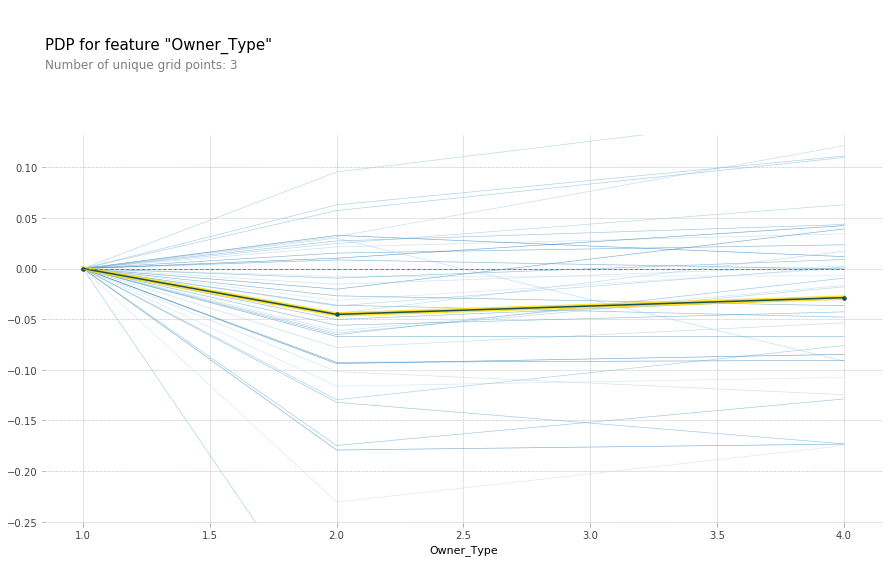

In [63]:
# pdp plot of Owner_Type using the xgbregressor model
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01);

In [30]:
# Shaply visualization of the first row of X_val_imputed
import shap

row = X_val_imputed[[0]]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)